/opt/anaconda3/envs/Zeolite/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:966: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/opt/anaconda3/envs/Zeolite/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


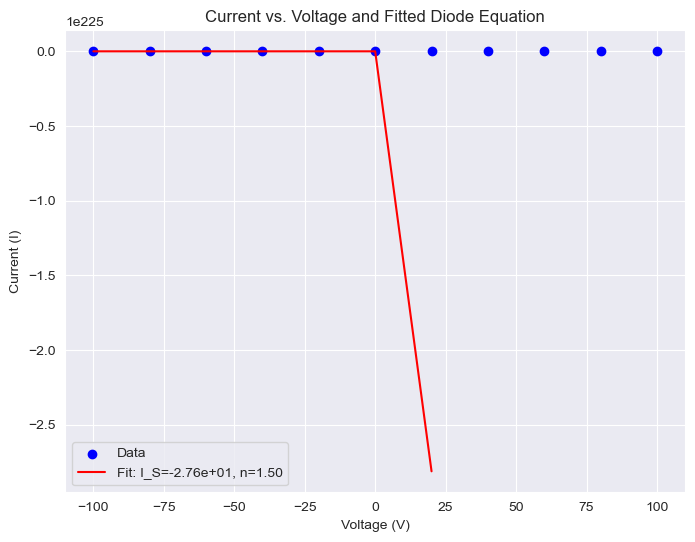

Fitted I_S (saturation current): 1.00e-12 A
Fitted ideality factor (n): 1.50


In [184]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_and_plot_diode_data(filename):
    """
    Fit a diode model to the data in the given file and plot the results.
    :param filename: 
    :return: 
    """
    def read_diode_data(filename):
        # Load data from a tab-separated file
        df = pd.read_csv(filename, sep='\t', header=None)

        # Drop the first row and reset the index
        df = df.drop(0, axis=0).reset_index(drop=True)

        # Drop the first column
        df = df.drop(0, axis=1)

        # Convert the first column to a PyTorch tensor representing voltage
        voltage = torch.tensor(df.iloc[:, 0].dropna().astype(float).values, dtype=torch.float64)

        # Convert the second column to a PyTorch tensor representing current
        current = torch.tensor(df.iloc[:, 1].dropna().astype(float).values, dtype=torch.float64)

        return voltage, current
    
    def diode_equation(V, I_S, n, V_T=25.85):
        """
        The diode equation.
    
        Parameters:
        - V: Voltage across the diode.
        - I_S: Saturation current (one of the parameters to fit).
        - n: Ideality factor (another parameter to fit).
        - V_T: Thermal voltage, default is 25.85 mV.
    
        Returns:
        - I: Current through the diode.
        """
        return I_S * (torch.exp(V / (n * V_T)) - 1)
    
    def transformed_diode_current(V, log_I_S, n, V_T=25.85):
        I_S = np.exp(log_I_S)  # Transform I_S back
        return diode_equation(V, I_S, n, V_T)
    # Transform during fitting
    V, I = read_diode_data(filename)
    search_space = [np.log(1e-12), 1.5]
    # Perform the curve fitting
    params, _ = curve_fit(diode_equation, V, I, p0=search_space)
    
    fitted_I_S = np.exp(params[0])
    fitted_n = params[1]
    # Plot the data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(V, I, label='Data', color='blue')
    plt.plot(V, diode_equation(V, *params), label='Fit: I_S=%.2e, n=%.2f' % tuple(params), color='red')
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (I)')
    plt.title('Current vs. Voltage and Fitted Diode Equation')
    plt.legend()
    plt.show()
    
    # Print the parameters
    print(f"Fitted I_S (saturation current): {fitted_I_S:.2e} A")
    print(f"Fitted ideality factor (n): {fitted_n:.2f}")

# Example usage:
fit_and_plot_diode_data('Diode.txt')